# Exploring Consistent Yearly Data
Sam Keyser

CS3300 - Winter '23

## Research Questions

In this notebook we seek to answer the following research questions:
1. What are the main factors of happiness?
2. What are the main factors of happiness?


We perform the standard EDA procedures that we learned in the class on the data. In particular we:
* Separate features into categorical / numerical
* Set correct types in pandas
* Clean the data
    * normalize text data
    * remove nulls
    * identify & potentially remove outliers
* visualize features independently
* visualize features in relation to target variable
* perform statistical testing

## Set up

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, kruskal, chi2_contingency
import pathlib
from dataset import *
from matplotlib import pyplot as plt
import geopandas as gpd

## Loading the Data
We use the [world happiness report](https://www.kaggle.com/datasets/mathurinache/world-happiness-report?select=2022.csv) dataset from kaggle, preprocessed to combine all the years into one dataframe, and restricted down into the subset of features consistent across all years:
* GDP per capita
* Social support
* Healthy life expectancy
* Freedom to make life choices
* Perceptions of corruption/trust in government
* Generosity
* Country name
* Country Rank
* Country Score

We also add a feature `year` for keeping track of what year a column came from.

In [2]:
df = get_consistent_yearly()

In [3]:
old_cols = df.columns

In [4]:
df[["country", "rank", "score", "gdp", "support", "expectancy", "freedom", "corruption", "generosity", "year"]] = df[df.columns]

In [5]:
df.columns

Index(['Country or region', 'Overall rank', 'Score', 'GDP per capita',
       'Social support', 'Healthy life expectancy',
       'Freedom to make life choices', 'Perceptions of corruption',
       'Generosity', 'year', 'country', 'rank', 'score', 'gdp', 'support',
       'expectancy', 'freedom', 'corruption', 'generosity'],
      dtype='object')

We replace the column names with easier to work with versions of themselves.

In [6]:
old_cols = list(old_cols)
old_cols.remove('year')
df = df.drop(columns=old_cols)

In [7]:
df.columns

Index(['year', 'country', 'rank', 'score', 'gdp', 'support', 'expectancy',
       'freedom', 'corruption', 'generosity'],
      dtype='object')

Next we normalize the `country` column. We perform some standard steps like removing special characters, unifying the casing, removing spaces, but we also do some specific normalizations related to artifacts we found while constructing this notebook. A lot of the specific artifacts related to the same country being presented in two slightly different ways. EX: `northcyprus` vs. `northerncyprus`.

In [8]:
df["country"] = df["country"].str.replace("[^a-zA-Z]","").str.replace(' ','').str.lower().str.replace('hongkong.+','hongkong').str.replace('czechia','czechrepublic').str.replace('taiwan.+','taiwan').str.replace('northern','north').str.replace('kingdomof','')

/tmp/ipykernel_77025/65253218.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df["country"] = df["country"].str.replace("[^a-zA-Z]","").str.replace(' ','').str.lower().str.replace('hongkong.+','hongkong').str.replace('czechia','czechrepublic').str.replace('taiwan.+','taiwan').str.replace('northern','north').str.replace('kingdomof','')


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230 entries, 0 to 1229
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   year        1230 non-null   int64 
 1   country     1230 non-null   object
 2   rank        1230 non-null   int64 
 3   score       1230 non-null   object
 4   gdp         1230 non-null   object
 5   support     1230 non-null   object
 6   expectancy  1230 non-null   object
 7   freedom     1230 non-null   object
 8   corruption  1229 non-null   object
 9   generosity  1230 non-null   object
dtypes: int64(2), object(8)
memory usage: 96.2+ KB


We note that we have **one null value** in `Perceptions of corruption`

In [10]:
df.head(n=10)

year      country  rank  score      gdp  support expectancy  freedom  \
0  2015  switzerland     1  7.587  1.39651  1.34951    0.94143  0.66557   
1  2015      iceland     2  7.561  1.30232  1.40223    0.94784  0.62877   
2  2015      denmark     3  7.527  1.32548  1.36058    0.87464  0.64938   
3  2015       norway     4  7.522    1.459  1.33095    0.88521  0.66973   
4  2015       canada     5  7.427  1.32629  1.32261    0.90563  0.63297   
5  2015      finland     6  7.406  1.29025  1.31826    0.88911  0.64169   
6  2015  netherlands     7  7.378  1.32944  1.28017    0.89284  0.61576   
7  2015       sweden     8  7.364  1.33171  1.28907    0.91087   0.6598   
8  2015   newzealand     9  7.286  1.25018  1.31967    0.90837  0.63938   
9  2015    australia    10  7.284  1.33358  1.30923    0.93156  0.65124   

  corruption generosity  
0    0.41978    0.29678  
1    0.14145     0.4363  
2    0.48357    0.34139  
3    0.36503    0.34699  
4    0.32957    0.45811  
5    0.41372    0.23351  
6    0.31814     0.4761  
7    0.43844    0.36262  
8    0.42922    0.47501  
9    0.35637    0.43562

In [11]:
cat = ["country", "rank", "year"]
num = list(set(df.columns)-set(cat))

While working on this section we found an interesting issue... because we're collecting european data we have to account for commas in their larger numbers!

In [12]:
for col in num:
    if df[col].str.contains(',').any():
        print(col, 'contains commas')

generosity contains commas
gdp contains commas
support contains commas
freedom contains commas
expectancy contains commas
corruption contains commas
score contains commas


In [13]:
for col in num:
    df[col] = df[col].astype(str).str.replace(',','.')

In [14]:
df[num].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230 entries, 0 to 1229
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   generosity  1230 non-null   object
 1   gdp         1230 non-null   object
 2   support     1230 non-null   object
 3   freedom     1230 non-null   object
 4   expectancy  1230 non-null   object
 5   corruption  1230 non-null   object
 6   score       1230 non-null   object
dtypes: object(7)
memory usage: 67.4+ KB


In [15]:
df[cat] = df[cat].astype("category")
df[num] = df[num].astype("float64")

In [16]:
df[num].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230 entries, 0 to 1229
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   generosity  1230 non-null   float64
 1   gdp         1230 non-null   float64
 2   support     1230 non-null   float64
 3   freedom     1230 non-null   float64
 4   expectancy  1230 non-null   float64
 5   corruption  1229 non-null   float64
 6   score       1230 non-null   float64
dtypes: float64(7)
memory usage: 67.4 KB


We verify that our types were correctly applied and that we generated no new NANs.

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230 entries, 0 to 1229
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        1230 non-null   category
 1   country     1230 non-null   category
 2   rank        1230 non-null   category
 3   score       1230 non-null   float64 
 4   gdp         1230 non-null   float64 
 5   support     1230 non-null   float64 
 6   expectancy  1230 non-null   float64 
 7   freedom     1230 non-null   float64 
 8   corruption  1229 non-null   float64 
 9   generosity  1230 non-null   float64 
dtypes: category(3), float64(7)
memory usage: 84.4 KB


## Exploring the Categorical Data

We define a utility function for splitting very large data up into chunks so that we can visualize in a reasonable fashion.

In [18]:
def split_to_bins(data, BIN_SIZE=25):
    bins = []

    ptr = 0
    while ptr < data.size:
        bins.append(data[ptr:min(ptr+BIN_SIZE,data.size)])
        ptr += BIN_SIZE

    return bins


We generate barplots showing each country's frequency of appearing. Effectively, we track how much each country participates.

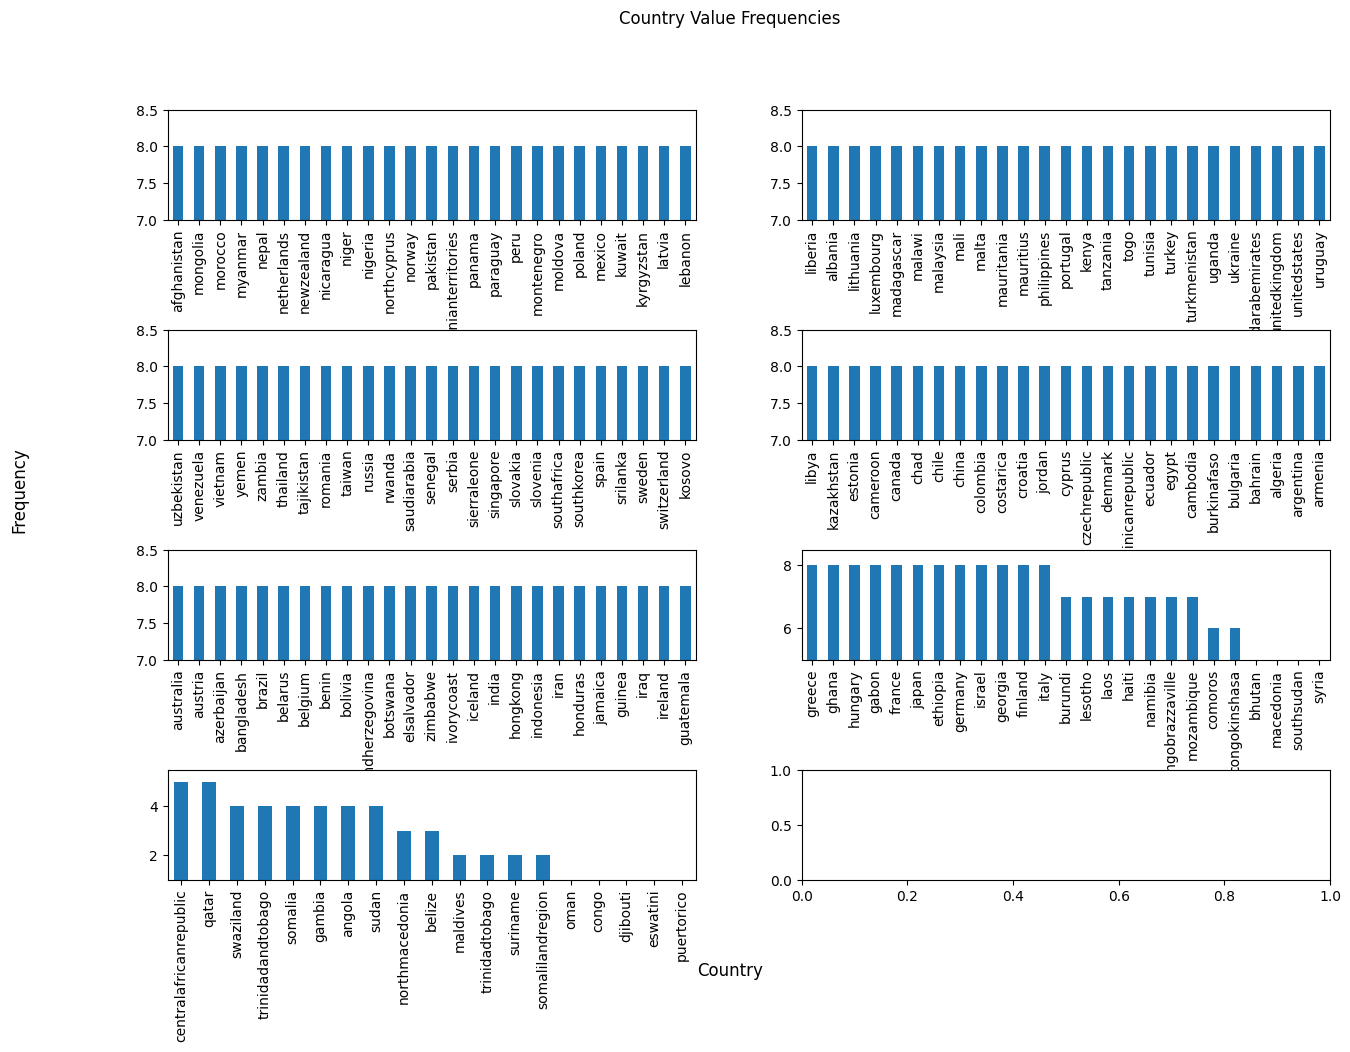

In [19]:
bins = split_to_bins(df["country"].value_counts())

fig, axs = plt.subplots(4,2)
fig.set_size_inches(15,10)
plt.subplots_adjust(hspace=1.0)

fig.suptitle("Country Value Frequencies")
fig.supxlabel("Country")
fig.supylabel("Frequency")

for _bin,ax in zip(bins,axs.ravel()):
    _bin.plot.bar(ax=ax)
    ax.set_ylim((_bin.min()-(1 if _bin.max()==_bin.min() else 0),_bin.max()+0.5))

Next we show the frequency at which ranks are assigned.

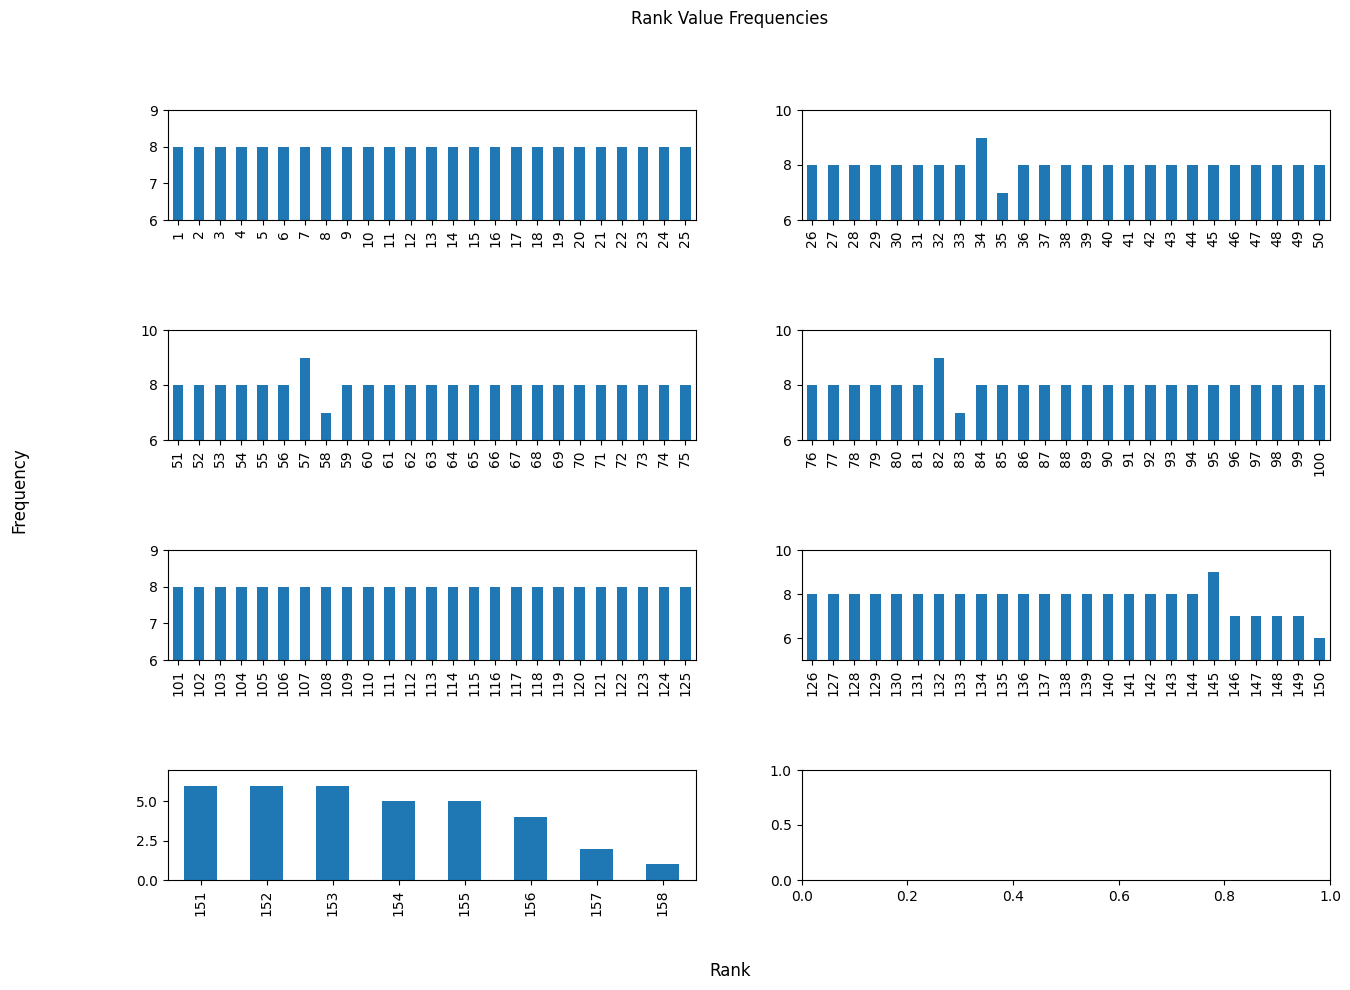

In [20]:
bins = split_to_bins(df["rank"].value_counts().sort_index())

fig, axs = plt.subplots(4,2)
fig.set_size_inches(15,10)
plt.subplots_adjust(hspace=1.0)

fig.suptitle("Rank Value Frequencies")
fig.supxlabel("Rank")
fig.supylabel("Frequency")

for _bin,ax in zip(bins,axs.ravel()):
    _bin.plot.bar(ax=ax)
    ax.set_ylim((_bin.min()-(1 if _bin.max()==_bin.min() else 0)-1,_bin.max()+1))

We note the presence of odd behavior for several ranks where one rank occurs much less frequently than its neighbors. Note that this almost always happens next to a rank which occurs more frequently than its neighbors. This is because in the case of a tie, two countries share the rank and the next sequential rank goes unused. 

On the trailing edge we can hypothesize that the rank frequencies are going down because different numbers of countries are participating per year, so the upper ranks will not be used consistently.

Next we plot the number of countries participating in the WHR per year. This will be important because it shows us how many records we have for each year bracket. It also explains why the upper ranks are not used as frequently.

<AxesSubplot:title={'center':'Number of Countries Participating per Year'}, xlabel='year'>

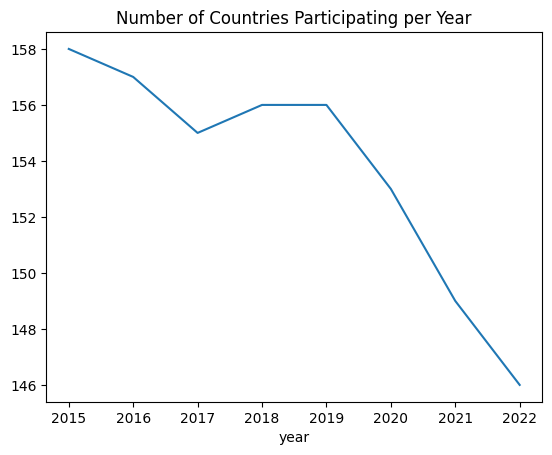

In [21]:
df.groupby('year')["country"].size().plot.line(title='Number of Countries Participating per Year')

## Exploring the Numerical

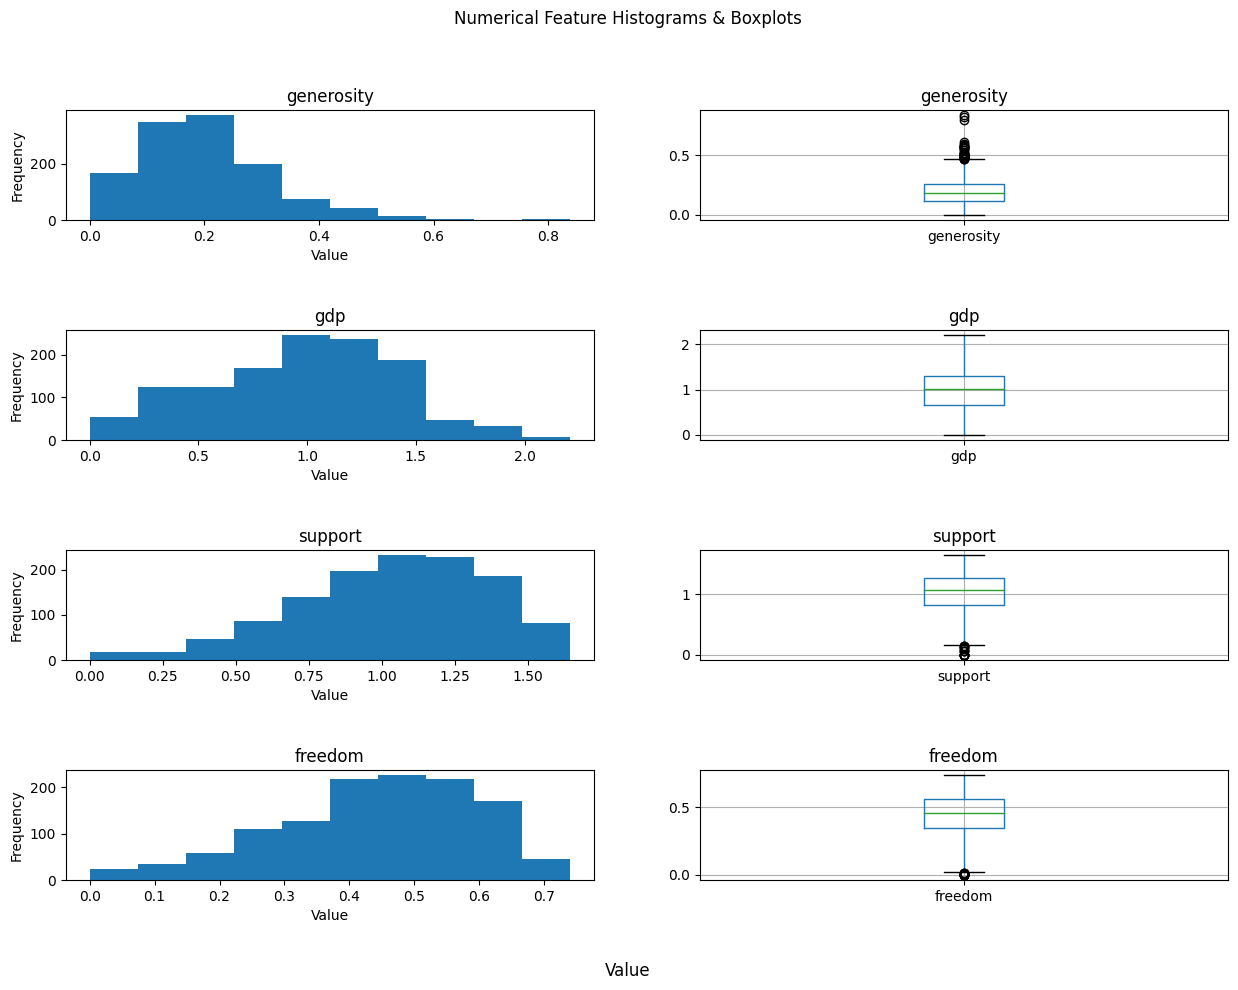

In [22]:
_bin = split_to_bins(df["gdp"])

fig, axs = plt.subplots(4,2)
fig.set_size_inches(15,10)
plt.subplots_adjust(hspace=1.0)

fig.suptitle('Numerical Feature Histograms & Boxplots')
fig.supxlabel('Value')

for col,lr_axs in zip(num[:4],axs):
    left, right = lr_axs
    df[col].plot.hist(title=col,ax=left)
    left.set_xlabel('Value')
    df.boxplot(column=col,ax=right).set_title(col)

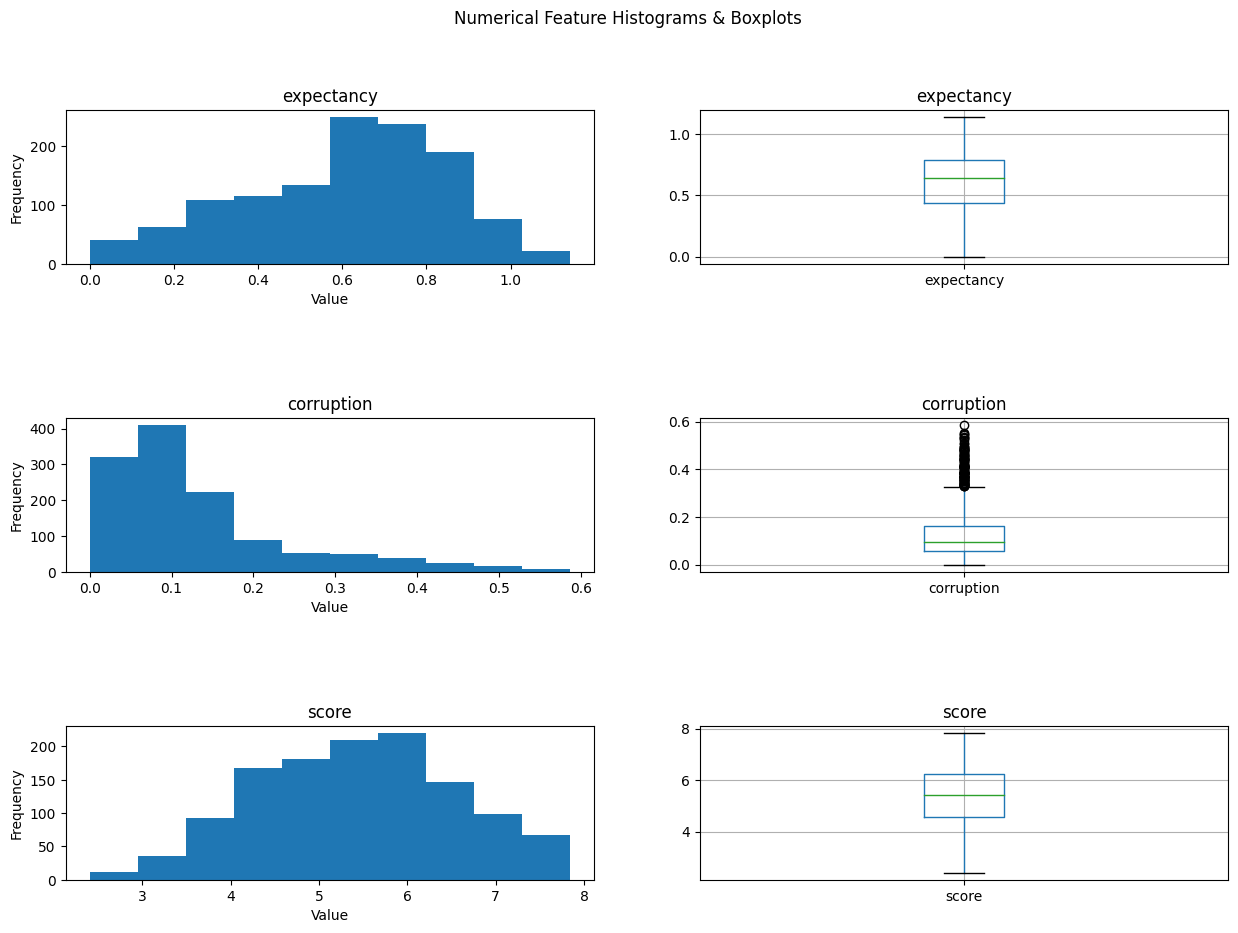

In [23]:
fig, axs = plt.subplots(3,2)
fig.set_size_inches(15,10)
plt.subplots_adjust(hspace=1.0)

fig.suptitle('Numerical Feature Histograms & Boxplots')

for col,lr_axs in zip(num[4:],axs):
    left, right = lr_axs
    df[col].plot.hist(title=col,ax=left)
    left.set_xlabel('Value')
    df.boxplot(column=col,ax=right).set_title(col)

We have some clear outliers in Geneorsity, healthy life expectancy, and GDP per capita. We have what looks like outliers in score, freedom, & social support too.

## Outlier Removal

We define a conservative outlier detection method which identifies the records which are equal to or greater than the 99th percentile, or less than or equal to the 1st percentile.

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230 entries, 0 to 1229
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        1230 non-null   category
 1   country     1230 non-null   category
 2   rank        1230 non-null   category
 3   score       1230 non-null   float64 
 4   gdp         1230 non-null   float64 
 5   support     1230 non-null   float64 
 6   expectancy  1230 non-null   float64 
 7   freedom     1230 non-null   float64 
 8   corruption  1229 non-null   float64 
 9   generosity  1230 non-null   float64 
dtypes: category(3), float64(7)
memory usage: 84.4 KB


In [25]:
var_masks = [(df[var] >= df[var].quantile(0.99))  | (df[var] <= df[var].quantile(0.01)) for var in num]
mask = var_masks[0]
for var_mask in var_masks[1:]:
    mask = mask | var_mask
df[mask]

year      country rank  score      gdp  support  expectancy  freedom  \
0     2015  switzerland    1  7.587  1.39651  1.34951     0.94143  0.66557   
1     2015      iceland    2  7.561  1.30232  1.40223     0.94784  0.62877   
23    2015    singapore   24  6.798  1.52186  1.02000     1.02525  0.54252   
27    2015        qatar   28  6.611  1.69042  1.07860     0.79733  0.64040   
33    2015     thailand   34  6.455  0.96690  1.26504     0.73850  0.55664   
...    ...          ...  ...    ...      ...      ...         ...      ...   
1225  2022     botswana  142  3.471  1.50300  0.81500     0.28000  0.57100   
1226  2022       rwanda  143  3.268  0.78500  0.13300     0.46200  0.62100   
1227  2022     zimbabwe  144  2.995  0.94700  0.69000     0.27000  0.32900   
1228  2022      lebanon  145  2.955  1.39200  0.49800     0.63100  0.10300   
1229  2022  afghanistan  146  2.404  0.75800  0.00000     0.28900  0.00000   

      corruption  generosity  
0        0.41978     0.29678  
1        0.14145     0.43630  
23       0.49210     0.31105  
27       0.52208     0.32573  
33       0.03187     0.57630  
...          ...         ...  
1225     0.10200     0.01200  
1226     0.54400     0.18700  
1227     0.10500     0.10600  
1228     0.03400     0.08200  
1229     0.00500     0.08900  

[150 rows x 10 columns]

In [26]:
mask.sum()

150

We have 150 outliers that we _could_ remove given the percentile criteria defined above. We decide not to remove any outliers because we want to preserve as much information as possible. Instead we only drop columns with NaN values.

In [27]:
df = df.dropna()

## Target Variable Analysis

Our target variables are `score` and `Overall rank` individually. For each target variable we go and make the appropriate visualizations for that variable vs. each of the numerical and categorical variables respectively.

### Using `score` as our Target Variable

#### Numerical Variables

In [28]:
num_no_score = [n for n in num if n != 'score']
num_no_score

['generosity', 'gdp', 'support', 'freedom', 'expectancy', 'corruption']

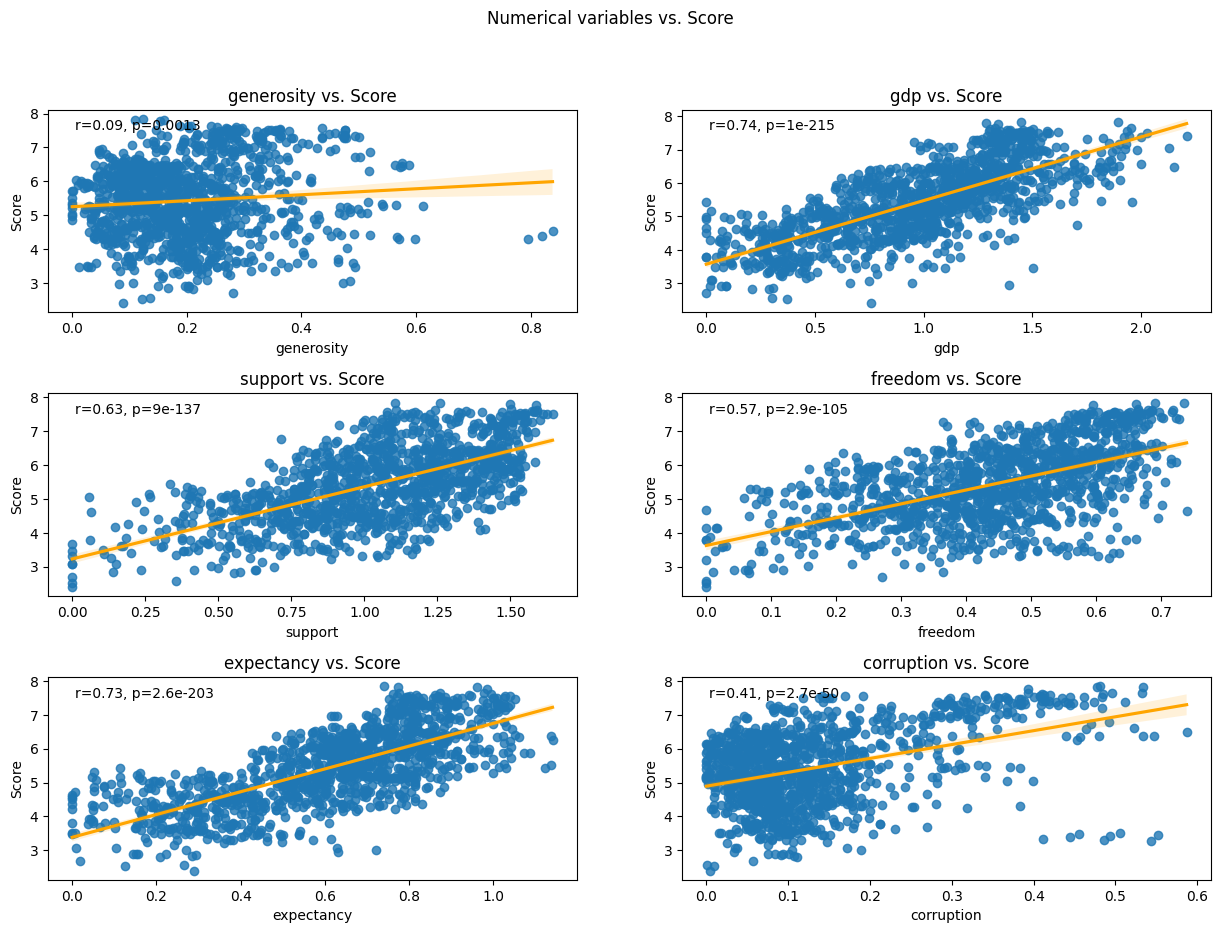

In [29]:
fig, axs = plt.subplots(3,2)
fig.set_size_inches(15,10)
plt.subplots_adjust(hspace=0.4)

fig.suptitle('Numerical variables vs. Score')
# fig.supxlabel('Variable')
# fig.supylabel('Score')

for var, ax in zip(num_no_score,axs.ravel()):
    #ax.scatter(df[var], df["Score"])
    sns.regplot(df, x=var,y="score",line_kws={"color": "orange"},ax=ax)
    
    r, p = pearsonr(df[var],df["score"])
    ax.text(.05, 0.90, 'r={:.2f}, p={:.2g}'.format(r,p), transform=ax.transAxes)
    
    ax.set_ylabel('Score')
    ax.set_xlabel(var)
    ax.set_title(f'{var} vs. Score')

#### Categorical Variables

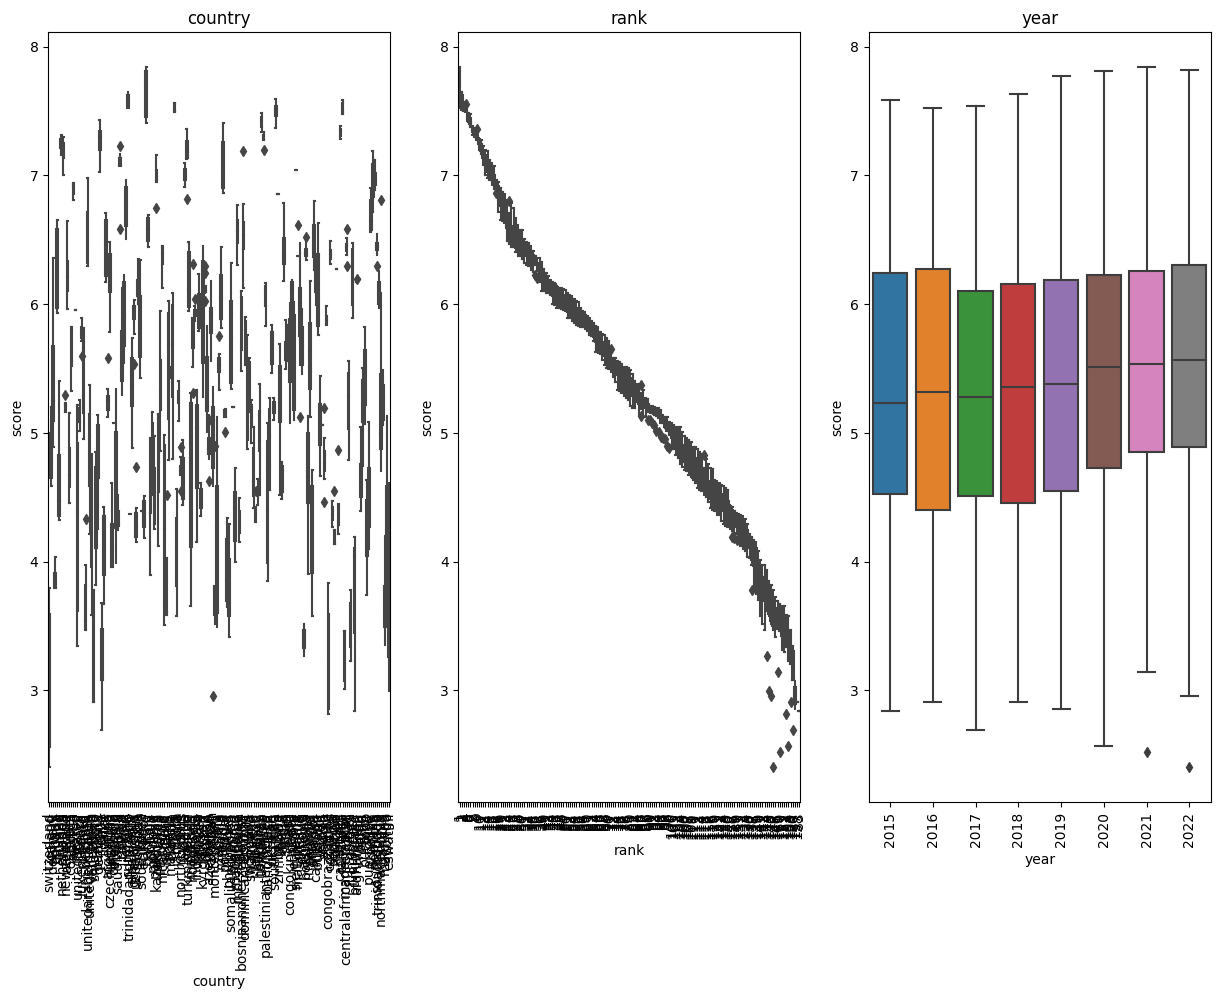

In [30]:
fig, axs = plt.subplots(1, len(cat))
fig.set_size_inches(15,10)

for var, ax in zip(cat, axs.ravel()):
    sns.boxplot(x=df[var],y=df["score"],ax=ax).set_title(var)
    ax.set_ylabel('score')
    ax.set_xlabel(var)
    ax.set_xticklabels(df[var].unique().astype(str), rotation=90)

Because we have a large number of groups in our categorical variables, our boxplots end up being very dense. While they're still useful to see general trends, we can't see the distributions for individual groups. Be break our plots for `country` and `rank` vs. score into several plots of small ranges of groups so that we can see the distributions for each group.


**NOTE:** score vs. rank is not plotted in this section, as it will be plotted in a later section anyways.

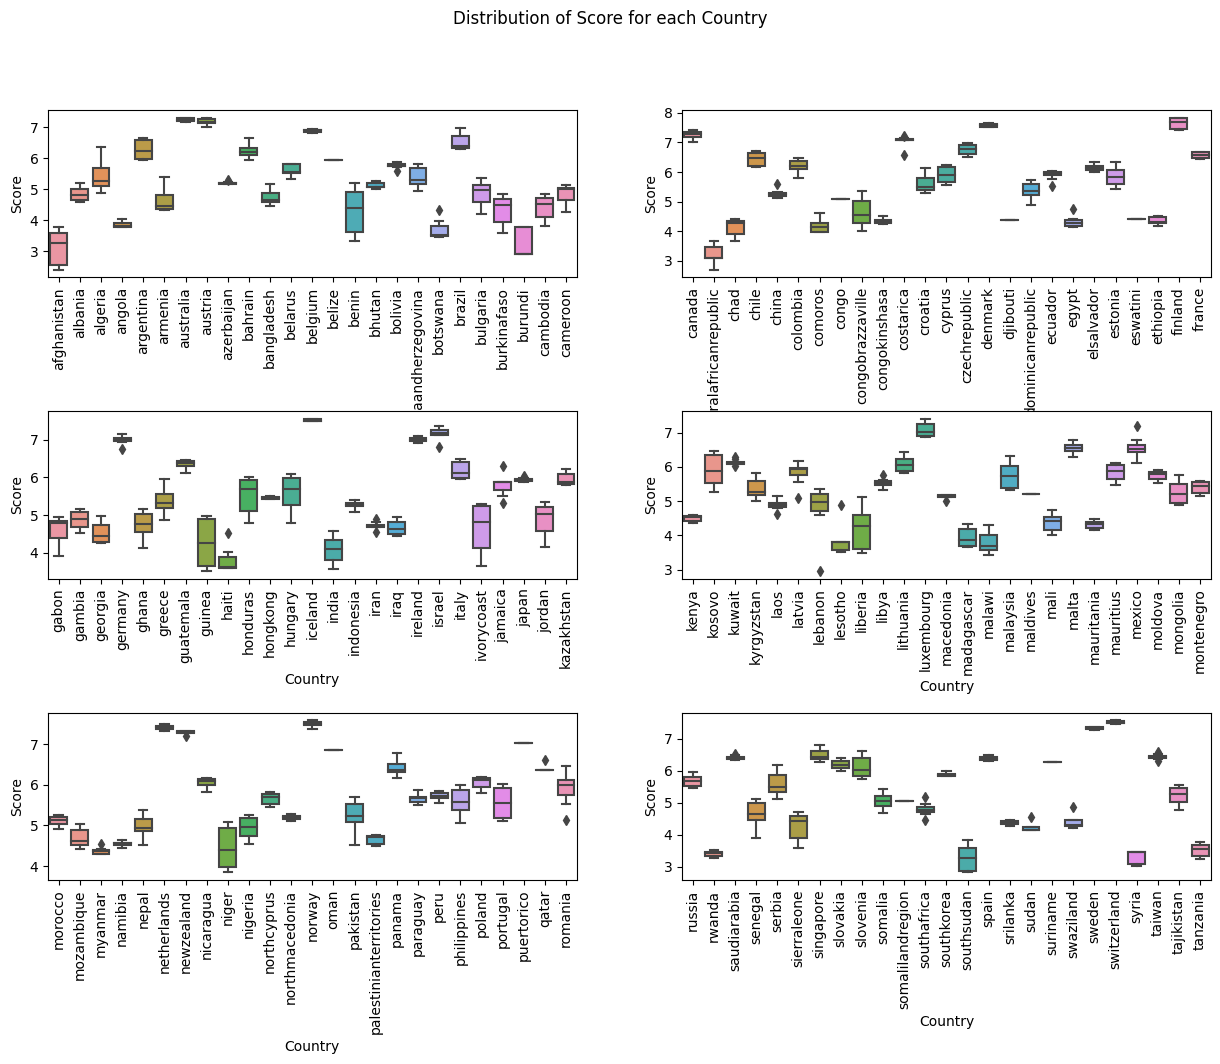

In [31]:
groups = [(grp, val['score']) for grp, val in df.groupby('country')]

fig, axs = plt.subplots(3,2)
fig.set_size_inches(15,10)
plt.subplots_adjust(hspace=0.8)

fig.suptitle('Distribution of Score for each Country')

axes = axs.ravel()

step = 25
start = 0
end = step

while end < len(groups):
    ax = axes[start//step]
    subset = groups[start:end]
    tmp = pd.DataFrame(subset,columns=["country","scores"]).explode(column="scores")
    sns.boxplot(x=tmp["country"].astype(str),y=tmp["scores"].astype(float),ax=ax)
    ax.set_xticklabels(tmp["country"].unique().astype(str), rotation=90)
    ax.set_ylabel('Score')
    ax.set_xlabel('Country')
    
    start = end
    end += step

del tmp

### Using `score` as our Target Variable

#### Numerical Variables

In [32]:
num

['generosity',
 'gdp',
 'support',
 'freedom',
 'expectancy',
 'corruption',
 'score']

In [33]:
df["rank"].unique().shape[0]

158

In [34]:
def binned_num_boxplots(numvar, df, subplot_shape=(2,2), step=40):
    fig,axs = plt.subplots(*subplot_shape)
    fig.set_size_inches(15,10)
    plt.subplots_adjust(hspace=0.6)

    fig.suptitle(f'{numvar} vs. rank split up into ranges')

    axes = axs.ravel()
    upper = np.unique(df['rank']).shape[0]
    
    min_y = min(df[numvar])
    max_y = max(df[numvar])
    
    def plot_binned_boxplot(var, start, end, axes, df):
        ax = axes[start//step]
        rank_slice = df[(df['rank'].astype(int) < end) & (df['rank'].astype(int) >= start)]

        sns.boxplot(x=rank_slice['rank'].astype(int),y=rank_slice[numvar],ax=ax).set_title(f"{start}-{end-1}")
        ax.set_xticklabels(list(range(start,end)), rotation=90)
        ax.set_xlabel('Rank')
        ax.set_ylabel(var)
        #ax.set_ylim((min_y,max_y))

    start = 1
    end = step
    while end < upper:
        plot_binned_boxplot(numvar, start, end, axes, df)
        start = end
        end += step

    end = upper+1
    plot_binned_boxplot(numvar, start, end, axes, df)

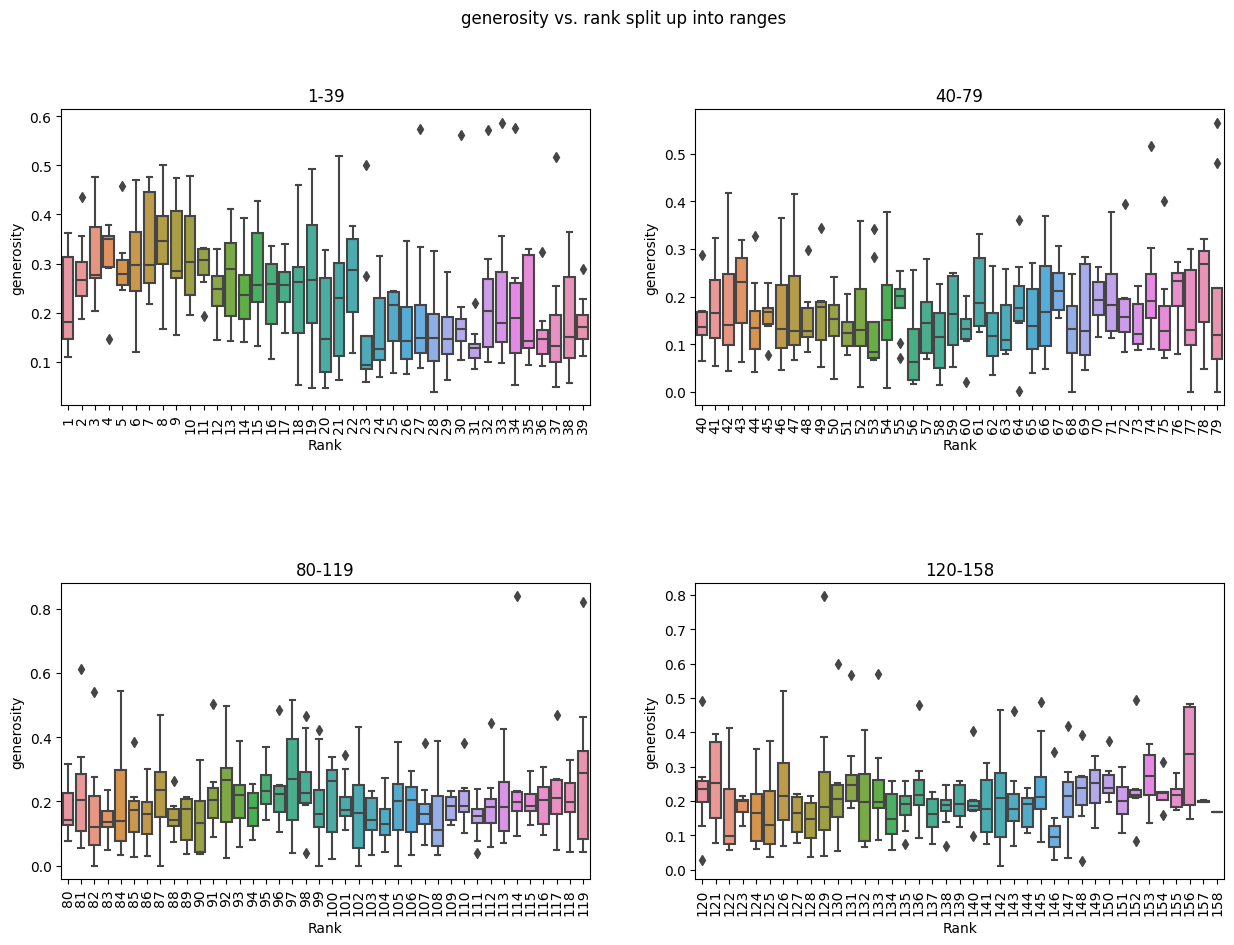

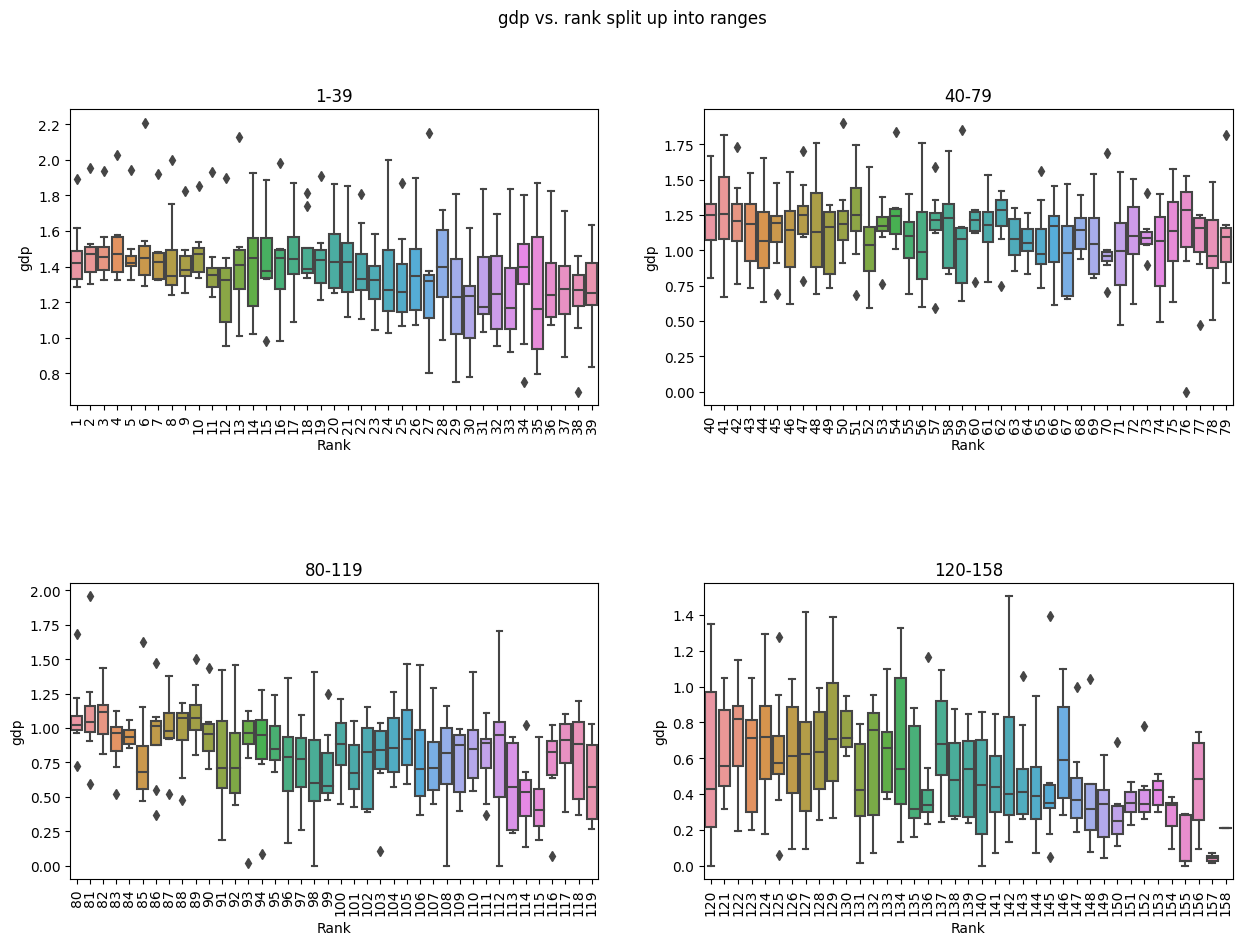

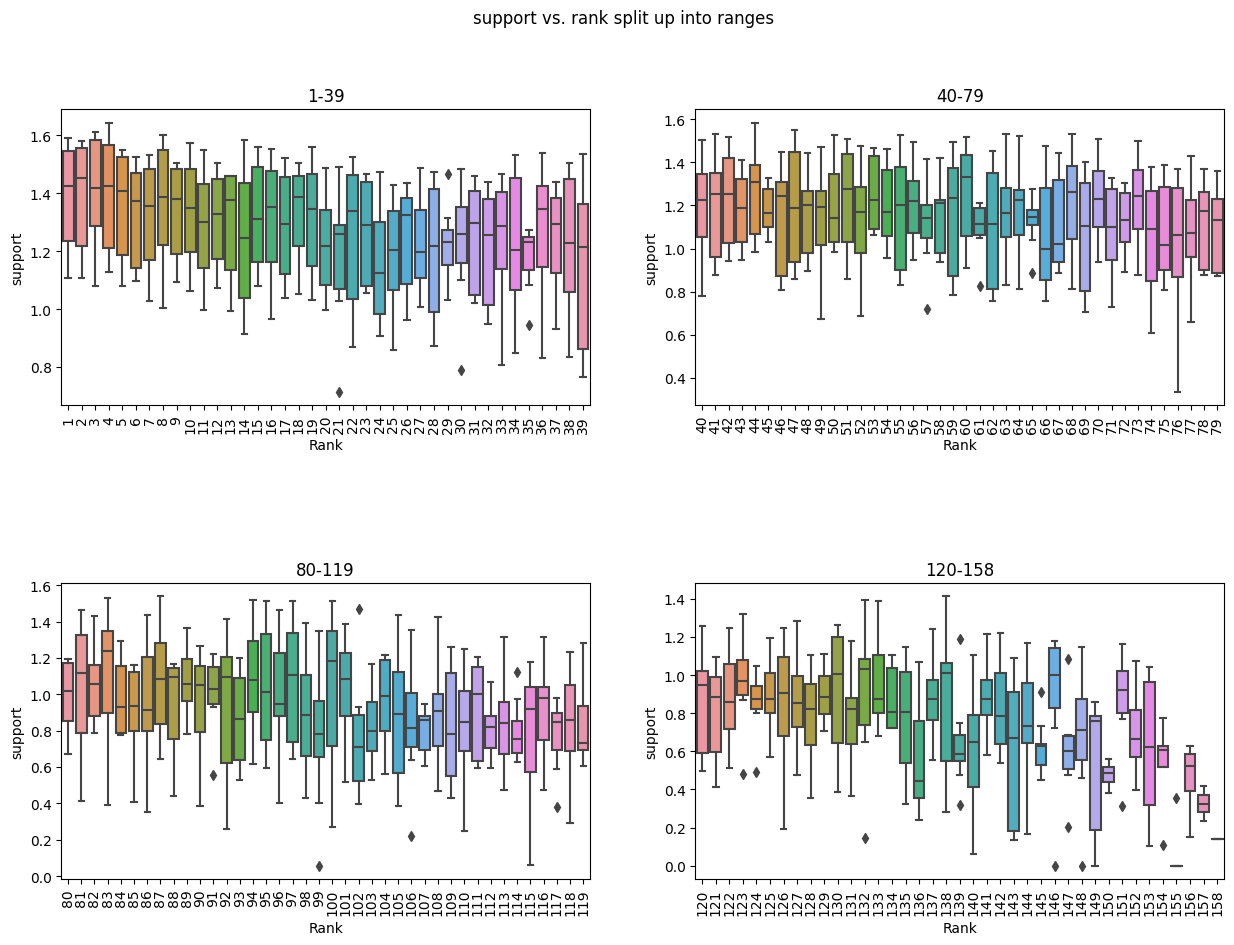

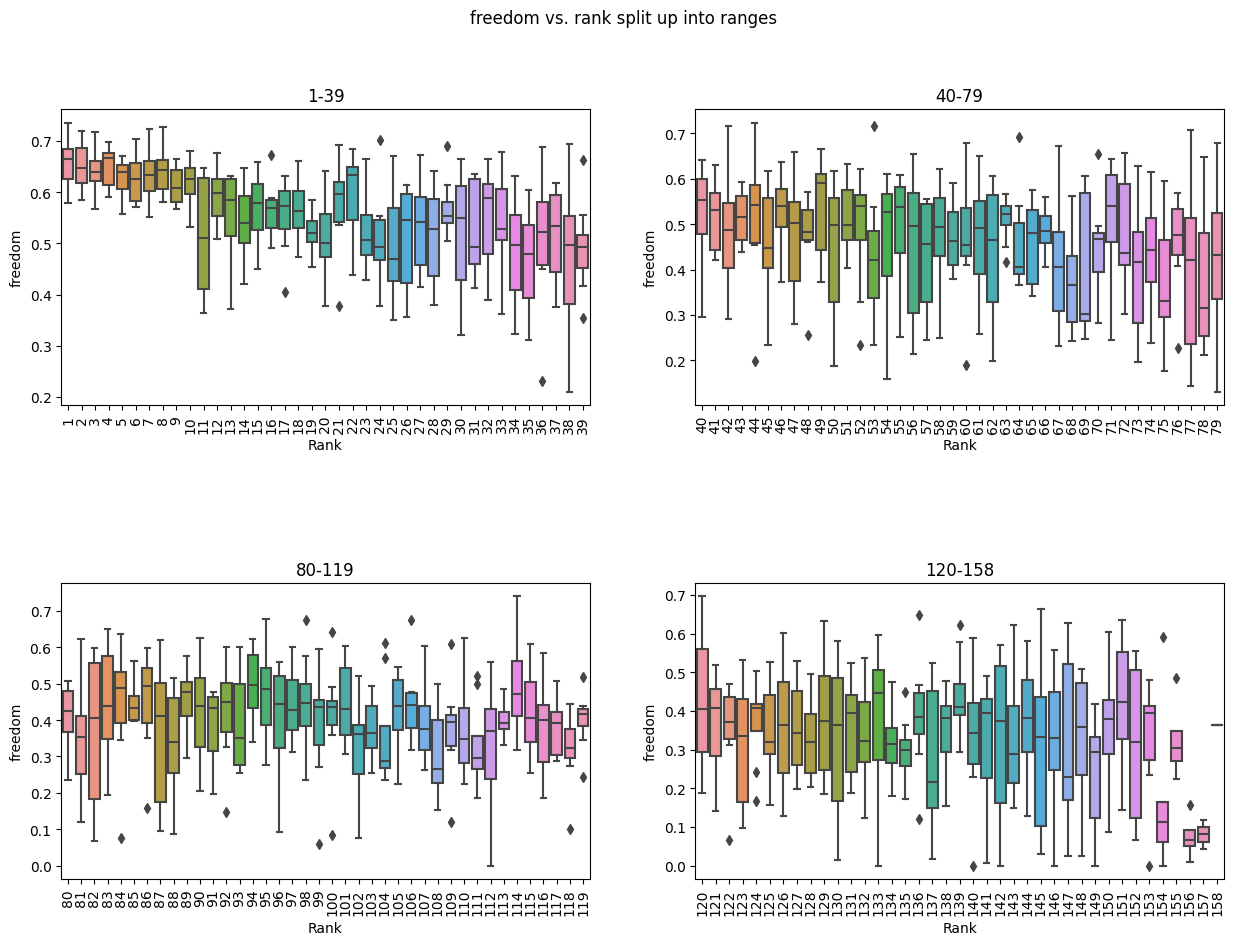

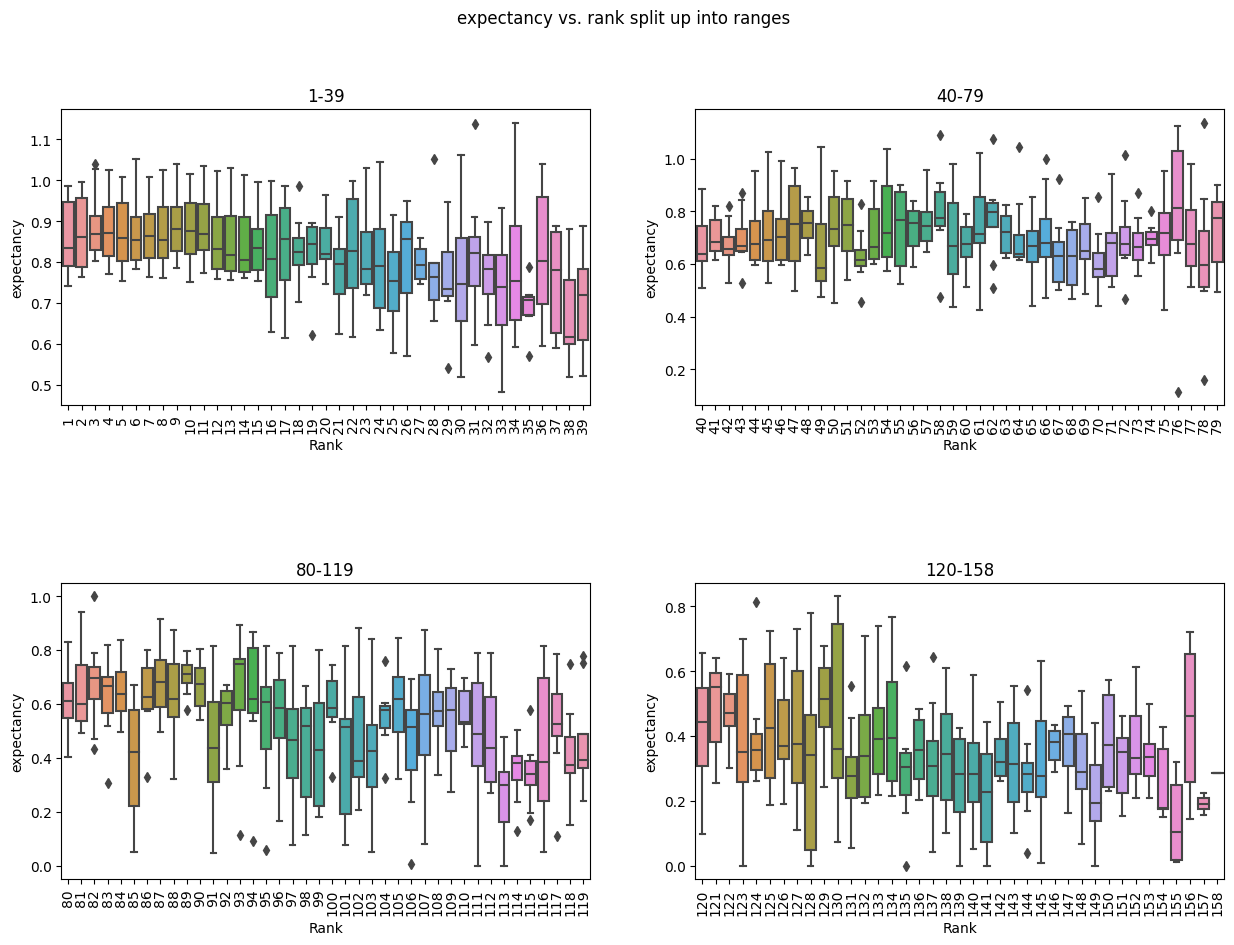

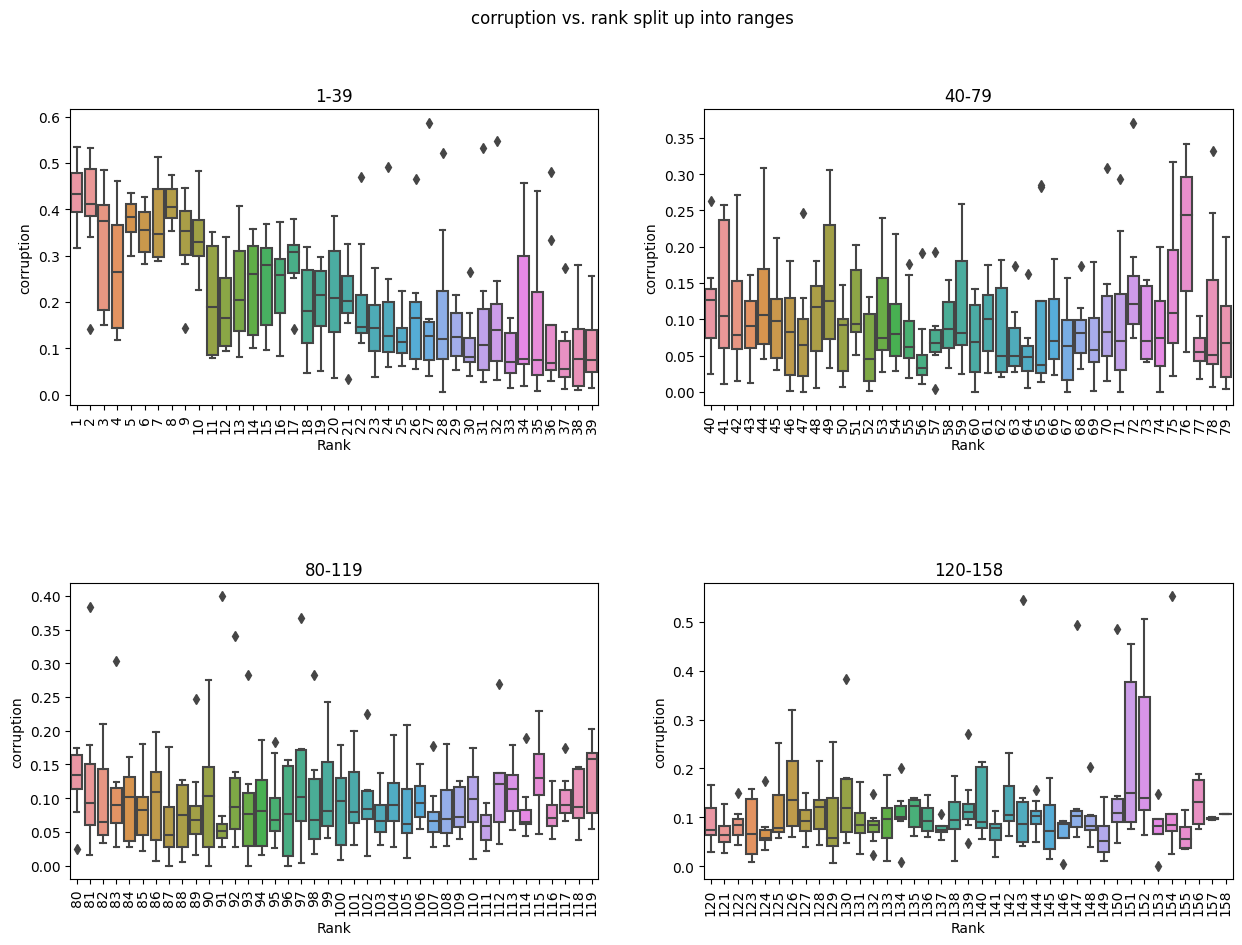

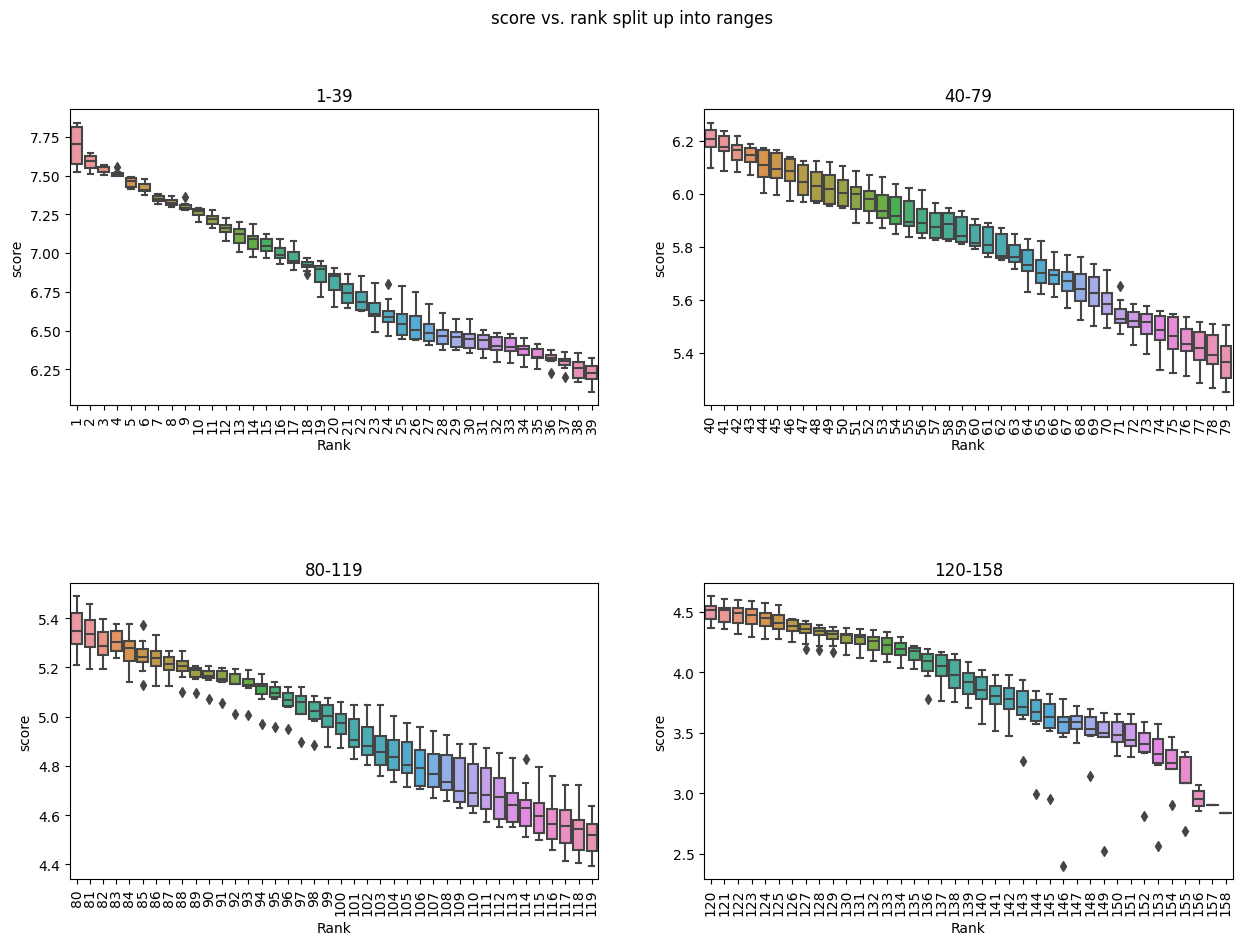

In [35]:
for var in num:
    binned_num_boxplots(var, df)

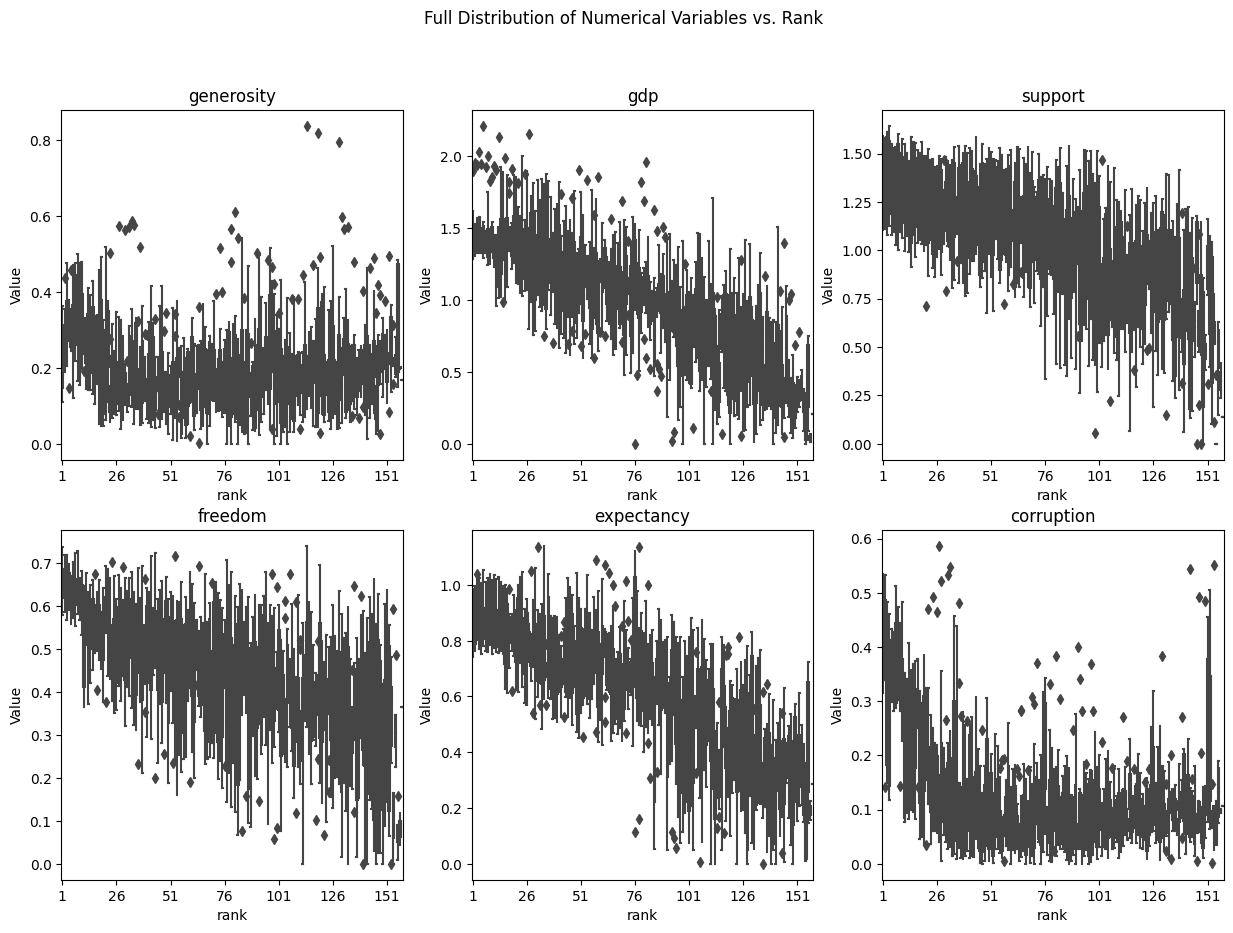

In [36]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(15,10)
#fig.subplots_adjust(hspace=0.6)

fig.suptitle('Full Distribution of Numerical Variables vs. Rank')

for var, ax in zip([n for n in num if n != 'score'], axs.ravel()):
    sns.boxplot(x=df["rank"],y=df[var],ax=ax).set_title(var)
    ax.set_ylabel('Value')
    ax.set_xlabel('rank')
    ax.set_xticks(df["rank"].unique().sort_values()[::25].astype(int) - 1) # I don't know why this works... :(

## Statistical Testing

### Score

#### Numerical

In [37]:
num

['generosity',
 'gdp',
 'support',
 'freedom',
 'expectancy',
 'corruption',
 'score']

Because we have mostly distributions of data, we choose **Pearson's correlation** for testing the correlation between any of our numerical variables (except score) and score.


To double check because some of our features are not exactly normal (generosity + corruption) we also compute **Spearman's correlation**.

In [38]:
def compute_pearson_spearman(df, x, y="score", alpha=0.01):
    p_stat, p_pval = pearsonr(df[x], df[y])
    s_stat, s_pval = spearmanr(df[x], df[y])
    return p_stat, p_pval, p_pval <= alpha, s_stat, s_pval, s_pval <= alpha

We compute a table for the Pearson and Spearman correlation coefficients and check to see if they are statistically significant using a $\alpha=0.01$.

In [39]:
pd.DataFrame(map(lambda var: compute_pearson_spearman(df,var), num_no_score),
             index=num_no_score, 
             columns=["Pearson Test Stat",
                      "Pearson Pval",
                      "Reject Pearson null hypothesis",
                      "Spearman Test Stat",
                      "Spearman Pval",
                      "Reject Spearman null hypothesis"])

Pearson Test Stat   Pearson Pval  Reject Pearson null hypothesis  \
generosity           0.091440   1.331563e-03                            True   
gdp                  0.742438  1.028792e-215                            True   
support              0.629771  8.989753e-137                            True   
freedom              0.566554  2.896740e-105                            True   
expectancy           0.727904  2.604584e-203                            True   
corruption           0.407241   2.695296e-50                            True   

            Spearman Test Stat  Spearman Pval  Reject Spearman null hypothesis  
generosity            0.074203   9.260169e-03                             True  
gdp                   0.762045  7.698710e-234                             True  
support               0.617241  5.948073e-130                             True  
freedom               0.563301  7.996655e-104                             True  
expectancy            0.744116  3.358280e-217                             True  
corruption            0.289362   3.921887e-25                             True

**All numerical features have a statistically significantly correlation with `score`.**

#### Categorical

We select the **Kruskal-Wallis** test for comparing a numerical and a categorical variable because we do not always have normally distributed data (in particular, country vs. score fails to present as normally distributed).

As before we perform the test with $\alpha=0.01$.

In [40]:
def kruskal_wallis(df, numerical, categorical, threshold=0.01):
    samples = []
    for value in set(df[categorical]):
        samples.append(df[numerical].dropna()[df[categorical]==value])
    stat, p = kruskal(*samples)
    return stat, p, p <= threshold, sum([s.size >= 5 for s in samples])/len(samples)

In [41]:
# Use the dataframe for table formatting :)
pd.DataFrame(map(lambda c: kruskal_wallis(df,"score",c),cat), 
             index=cat, 
             columns=["test stat", 
                      "p-val", 
                      "statistically significant"+\
                          " / reject the null hypothesis", 
                      "% of groups with # samples >= 5"])

test stat          p-val  \
country  1155.262074  6.700991e-147   
rank     1222.724975  2.389382e-164   
year        6.007242   5.389040e-01   

         statistically significant / reject the null hypothesis  \
country                                               True        
rank                                                  True        
year                                                 False        

         % of groups with # samples >= 5  
country                         0.899408  
rank                            0.981013  
year                            1.000000

We find that **we reject the null hypothesis for country and rank**, but that **we fail to reject the null hypothesis for year**.


This means that both country and rank have at least one group with a different median score than the others, while year has no groups with a statistically significantly different median score.

### Rank

#### Numerical


Because we are comparing a numerical vs. a categorical variable and we fail normality assumptions we use **Kruskal-Wallis** again.

In [42]:
# Use the dataframe for table formatting :)
pd.DataFrame(map(lambda n: kruskal_wallis(df,n,"rank"),num), 
             index=num, 
             columns=["test stat", 
                      "p-val", 
                      "statistically significant"+\
                          " / reject the null hypothesis", 
                      "% of groups with # samples >= 5"])

test stat          p-val  \
generosity   256.278006   9.534695e-07   
gdp          753.336635   1.107289e-78   
support      542.794694   5.969642e-44   
freedom      483.860824   5.323381e-35   
expectancy   753.032619   1.249501e-78   
corruption   403.197273   1.399395e-23   
score       1222.724975  2.389382e-164   

            statistically significant / reject the null hypothesis  \
generosity                                               True        
gdp                                                      True        
support                                                  True        
freedom                                                  True        
expectancy                                               True        
corruption                                               True        
score                                                    True        

            % of groups with # samples >= 5  
generosity                         0.981013  
gdp                                0.981013  
support                            0.981013  
freedom                            0.981013  
expectancy                         0.981013  
corruption                         0.981013  
score                              0.981013

**We are able to reject the null hypothesis for all numerical features**. This means that each feature has at least one group which has a statistically significant different median than the other groups.

#### Categorical

Because we are comparing two categorical variables we need to use the $\chi^2$ test for independence.

In [43]:
def chi_sq_indep(column, versus="rank", threshold=0.01):
    crosstab = pd.crosstab(df[column], df[versus])
    chi2, p, _, expected = chi2_contingency(crosstab)
    N = np.product(crosstab.shape)
    return chi2, p, p <= threshold, np.count_nonzero(expected < 1)/N, np.count_nonzero(expected < 5)/N

In [44]:
pd.DataFrame(map(chi_sq_indep,[c for c in cat if c != 'rank']), 
             index=[c for c in cat if c != 'rank'], 
             columns=["test stat", 
                      "p-val", 
                      "reject the null hypothesis", 
                      "% Expected < 1", "% Expected < 5"])

test stat          p-val  reject the null hypothesis  \
country  33339.838584  7.574747e-173                        True   
year        41.335816   1.000000e+00                       False   

         % Expected < 1  % Expected < 5  
country        1.000000             1.0  
year           0.432753             1.0

**We are able to reject the null hypothesis for country** but we **fail to reject the null hypothesis for year**. **Note that we fail assumptions for chi-2 for both.**


Thus we can say there is an association between rank and country, but not between year and rank.

## Plotting Features by Continent

As a final bit of EDA work, we want to see what each feature looks like for entire continents so we can get a sense of how regions of the world compare to each other.

We import the [world population](https://www.kaggle.com/datasets/iamsouravbanerjee/world-population-dataset) dataset from kaggle. The dataset provides several features but we only care about two:
* Country/Territory
* Continent


Using these two features we can join the population dataset to our world happiness dataset to identify the continent that each country is associated with.

### Getting each Country's Continent

We load in a second dataframe, which contains pairings of countries to continents. We can merge this with our main dataframe to get what continent each country is part of.

In [45]:
country_to_continent = get_population()[["Country/Territory","Continent"]]

In [46]:
country_to_continent["Country/Territory"] = country_to_continent["Country/Territory"].str.replace(' ','').str.lower()
country_to_continent = country_to_continent.set_index('Country/Territory').to_dict()['Continent']

We check to see if we have any countries whose continent we do not know from the supplementary data set.

In [47]:
unknown_countries = list(df[(~df["country"].apply(lambda c: country_to_continent.get(c,None)).notnull())]["country"].unique())
unknown_countries

['northcyprus',
 'kosovo',
 'somalilandregion',
 'macedonia',
 'swaziland',
 'palestinianterritories',
 'congokinshasa',
 'congobrazzaville',
 'trinidadtobago',
 'congo']

This is a small enough subset that we can just manually label these countries

In [48]:
labels = [
    "Europe",
    "Europe",
    "Africa",
    "Europe",
    "Africa",
    "Asia",
    "Africa",
    "Africa",
    "South America",
    "Africa"
]

In [49]:
country_to_continent.update({k: v for k, v in zip(unknown_countries,labels)})

We check again to make sure that we accounted for all the unknown countries.

In [50]:
list(df[(~df["country"].apply(lambda c: country_to_continent.get(c,None)).notnull())]["country"].unique())

[]

We have no more countries whose continent we do not know, so we can move forward with creating our continent feature.

In [51]:
df["continent"] = df["country"].apply(lambda c: country_to_continent.get(c,None))

### Generating Plots

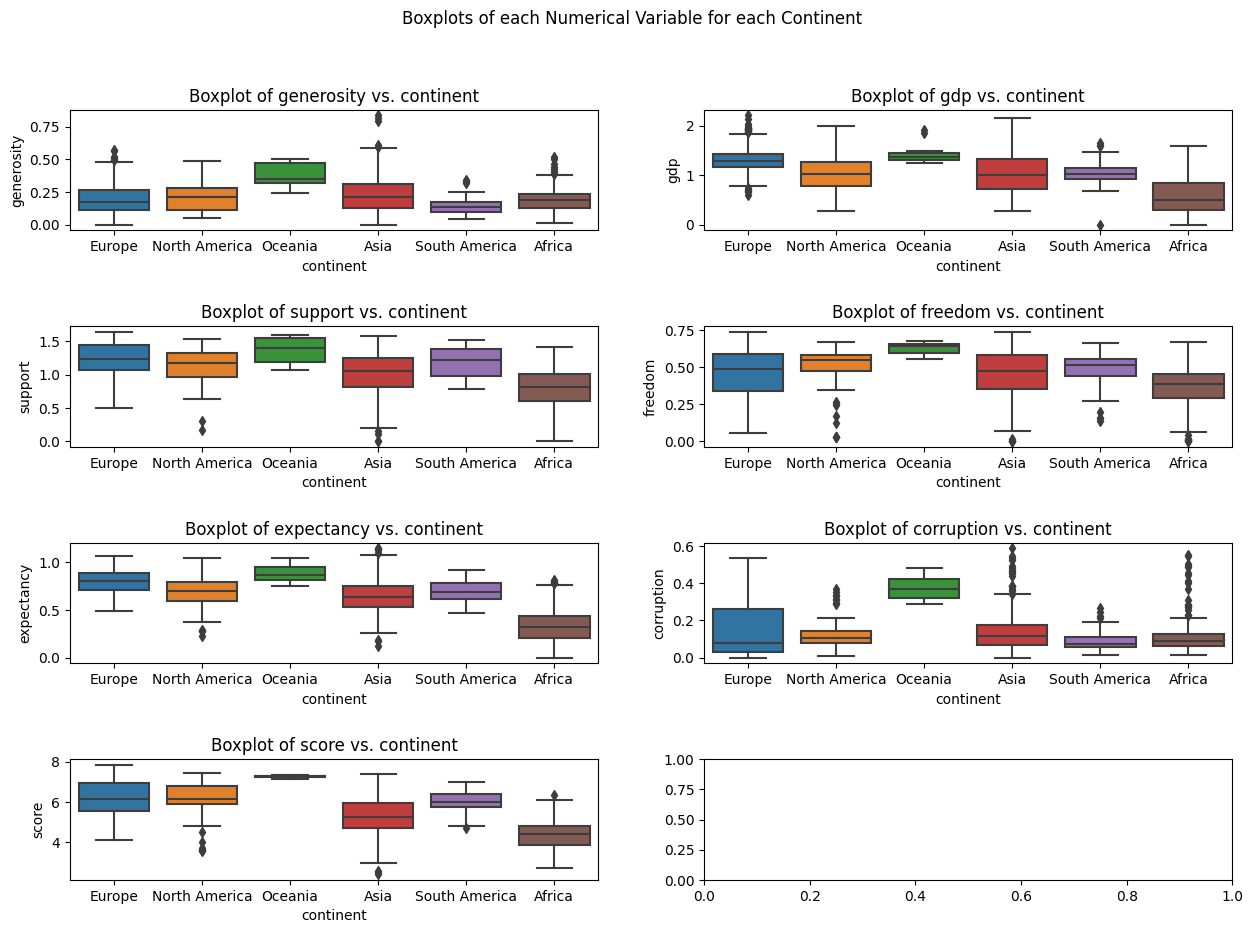

In [52]:
fig, axs = plt.subplots(4,2)
fig.set_size_inches(15,10)
plt.subplots_adjust(hspace=0.8)

fig.suptitle('Boxplots of each Numerical Variable for each Continent')

for var, ax in zip(num,axs.ravel()):
    sns.boxplot(x=df["continent"],y=df[var],ax=ax)
    
    ax.set_ylabel(var)
    ax.set_title(f'Boxplot of {var} vs. continent')
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=35)